# Lab 2, Classification

# Group 1, Ben Goodwin and Andre Mauldin

In this analysis we will build upon the mini project and add additional modeling from new classification techniques.

We will classify if a given flight will have an on time arrival or not

We will regress the arrival delay length given a delay type, operating airline, origin airport, and month.  


# Data Preperation Part I

In [2]:
#import libraries
from __future__ import print_function

import pandas as pd
import numpy as np

#Read in the flight delay data
#Our data is from Department of transportation
#https://www.bts.gov/topics/airlines-and-airports/number-14-time-reporting
df = pd.read_csv('2018.csv') # read in the csv file
#df.info()

#Reduce dataset to a more manageable size.
#We randomly sampled 150,000 records.  This is a reasonable sample size that will not cause excessively long computation times
dfReduced=df.sample(n=150000, random_state=1)

### Cleaning up the Data

Next, we create an array of each type of delay. This will be helpful as we will need to handle the missing values for the delays.

In [3]:
#Remove attributes that just arent useful for us
#Each of these variables removed is either of no use or can be derived using other variables in dataset. 
del dfReduced['DIVERTED']
del dfReduced['DISTANCE']
del dfReduced['TAXI_OUT']
del dfReduced['TAXI_IN']
del dfReduced['Unnamed: 27']
del dfReduced['CANCELLED']
del dfReduced['CANCELLATION_CODE']
del dfReduced['DEST']
del dfReduced['OP_CARRIER_FL_NUM']
del dfReduced['WHEELS_ON']
del dfReduced['DEP_TIME']
del dfReduced['WHEELS_OFF']
del dfReduced['CRS_DEP_TIME']


#Bring all delay types into one variable "delayArr"
dfReduced.info()
delayArr = [
    'DEP_DELAY'
    ,'ARR_DELAY'
    ,'CARRIER_DELAY'
    ,'WEATHER_DELAY'
    ,'NAS_DELAY'
    ,'SECURITY_DELAY'
    ,'LATE_AIRCRAFT_DELAY'
]
dfReduced[delayArr].describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 695058 to 499540
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   FL_DATE              150000 non-null  object 
 1   OP_CARRIER           150000 non-null  object 
 2   ORIGIN               150000 non-null  object 
 3   DEP_DELAY            147518 non-null  float64
 4   CRS_ARR_TIME         150000 non-null  int64  
 5   ARR_TIME             147492 non-null  float64
 6   ARR_DELAY            147112 non-null  float64
 7   CRS_ELAPSED_TIME     150000 non-null  float64
 8   ACTUAL_ELAPSED_TIME  147165 non-null  float64
 9   AIR_TIME             147165 non-null  float64
 10  CARRIER_DELAY        28035 non-null   float64
 11  WEATHER_DELAY        28035 non-null   float64
 12  NAS_DELAY            28035 non-null   float64
 13  SECURITY_DELAY       28035 non-null   float64
 14  LATE_AIRCRAFT_DELAY  28035 non-null   float64
dtypes: float64(1

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,147518.00000,147112.00000,28035.00000,28035.00000,28035.00000,28035.00000,28035.00000
mean,9.90160,4.97184,19.25297,3.53080,15.95798,0.08935,25.82215
std,45.12021,47.21904,60.43911,27.28905,36.98216,3.13707,51.35604
min,-43.00000,-77.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,-5.00000,-14.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,-2.00000,-6.00000,0.00000,0.00000,3.00000,0.00000,3.00000
75%,7.00000,8.00000,17.00000,0.00000,20.00000,0.00000,31.00000
max,1603.00000,1594.00000,1594.00000,976.00000,1205.00000,398.00000,1379.00000


In [4]:
#Here we take the date of the flight and place it into a month so that we can investiage seasonal trends and create our
#outcome variable of "ON_TIME_ARRIVAL."  This is what we will be predicting
dfReduced['MONTH'] = dfReduced['FL_DATE'].str[5:7]
conditions = [
    (dfReduced['CRS_ARR_TIME'] >= dfReduced['ARR_TIME']),
    (dfReduced['CRS_ARR_TIME'] < dfReduced['ARR_TIME'])]
choices = [1, 0]

dfReduced['ON_TIME_ARRIVAL'] = np.select(conditions, choices, default='null')

We are dropping rows that are NA for arrival time, expected arrival time, actual elapsed time, and air time. We are only interested in flights that arrived at their destination.

Arrival time is needed to calculate OTA in order to train the model. ACTUAL_ELAPSED_TIME and AIR_TIME are related to the how long it took to flight to arrive at it's destination. We drop the NAs because only flights that actually arrive will have a value.

For our delay variables, we set the NAs to 0.0, meaning there was no delay.  The previous value wa NaN which can't be calculated using logistic regression.

In [5]:
# We are only interested in flights that actually arrived.
# NAs are very few for these columns.  We will drop them.
dfReduced = dfReduced.dropna(subset=['ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

# Set NaN values to 0.0 to show zero minutes for delay time. Used array and for loop to avoid repetetive code

def replaceNaN(data, arr):
    for delayType in arr:
        data[delayType] = data[delayType].fillna(0.0)
    return data

dfReduced = replaceNaN(dfReduced, delayArr)


In [6]:
#Now that we have month, lets get rid of FL_DATE as the information is captured
del dfReduced['FL_DATE']
#Lets reduce to top 10 airports by passengers for 2018
#https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States#Busiest_U.S._airports_by_total_passenger_traffic_(2018)
dfReduced=dfReduced[dfReduced.ORIGIN.eq("ATL")| dfReduced.ORIGIN.eq("LAX")| dfReduced.ORIGIN.eq("ORD")| dfReduced.ORIGIN.eq("DFW")| dfReduced.ORIGIN.eq("DEN")| dfReduced.ORIGIN.eq("JFK")| dfReduced.ORIGIN.eq("SFO")| dfReduced.ORIGIN.eq("SEA")| dfReduced.ORIGIN.eq("LAS")| dfReduced.ORIGIN.eq("MCO")]
#print(dfReduced)
dfReduced[['OP_CARRIER','ORIGIN','MONTH','ON_TIME_ARRIVAL']].describe().transpose()

#Make sure datatypes for all variables are good to go
dfReduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45284 entries, 929508 to 6830663
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OP_CARRIER           45284 non-null  object 
 1   ORIGIN               45284 non-null  object 
 2   DEP_DELAY            45284 non-null  float64
 3   CRS_ARR_TIME         45284 non-null  int64  
 4   ARR_TIME             45284 non-null  float64
 5   ARR_DELAY            45284 non-null  float64
 6   CRS_ELAPSED_TIME     45284 non-null  float64
 7   ACTUAL_ELAPSED_TIME  45284 non-null  float64
 8   AIR_TIME             45284 non-null  float64
 9   CARRIER_DELAY        45284 non-null  float64
 10  WEATHER_DELAY        45284 non-null  float64
 11  NAS_DELAY            45284 non-null  float64
 12  SECURITY_DELAY       45284 non-null  float64
 13  LATE_AIRCRAFT_DELAY  45284 non-null  float64
 14  MONTH                45284 non-null  object 
 15  ON_TIME_ARRIVAL      45284 no

### Perform One-Hot encoding of categorical data

#### Remove other unused variables

#### Also remove variables that are captured in other variables

In [7]:
# perform one-hot encoding of the categorical data "OP_CARRIER"
tmp_df = pd.get_dummies(dfReduced.OP_CARRIER,prefix="Operating Carrier")
dfReduced = pd.concat((dfReduced,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "ORIGIN"
tmp_df = pd.get_dummies(dfReduced.ORIGIN,prefix="Origin")
dfReduced = pd.concat((dfReduced,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(dfReduced.MONTH,prefix="Month")
dfReduced = pd.concat((dfReduced,tmp_df),axis=1)


#Kill variables we hot-encoded
del dfReduced['OP_CARRIER']
del dfReduced['ORIGIN']
del dfReduced['MONTH']

#Create new DF for Regression Problem
#If a flight is delayed, which delay type produces long delays?
dfReg = dfReduced.copy()

#Kill Varibles we no longer need because they are encoded in ON_TIME_ARRIVAL
del dfReduced['ARR_TIME']
del dfReduced['CRS_ARR_TIME']
del dfReduced['CRS_ELAPSED_TIME']

#Drop Arr_delay, because this is essentially a proxy for 'ON_TIME_ARRIVAL'
del dfReduced['ARR_DELAY']

dfReduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45284 entries, 929508 to 6830663
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DEP_DELAY             45284 non-null  float64
 1   ACTUAL_ELAPSED_TIME   45284 non-null  float64
 2   AIR_TIME              45284 non-null  float64
 3   CARRIER_DELAY         45284 non-null  float64
 4   WEATHER_DELAY         45284 non-null  float64
 5   NAS_DELAY             45284 non-null  float64
 6   SECURITY_DELAY        45284 non-null  float64
 7   LATE_AIRCRAFT_DELAY   45284 non-null  float64
 8   ON_TIME_ARRIVAL       45284 non-null  object 
 9   Operating Carrier_9E  45284 non-null  uint8  
 10  Operating Carrier_AA  45284 non-null  uint8  
 11  Operating Carrier_AS  45284 non-null  uint8  
 12  Operating Carrier_B6  45284 non-null  uint8  
 13  Operating Carrier_DL  45284 non-null  uint8  
 14  Operating Carrier_EV  45284 non-null  uint8  
 15  Operating Ca

         DEP_DELAY  ACTUAL_ELAPSED_TIME  AIR_TIME  CARRIER_DELAY  \
929508    0.149042             0.232628  0.208909            0.0   
2390254   0.023314             0.063444  0.052227            0.0   
1797438   0.094088             0.441088  0.414747            0.0   
4821960   0.024147             0.067976  0.066052            0.0   
4330544   0.059117             0.048338  0.035330            0.0   
...            ...                  ...       ...            ...   
2987493   0.023314             0.365559  0.347158            0.0   
4443275   0.024979             0.312689  0.302611            0.0   
5364170   0.019151             0.125378  0.113671            0.0   
5364381   0.034138             0.206949  0.199693            0.0   
6830663   0.017485             0.410876  0.414747            0.0   

         WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  \
929508        0.000000   0.163063             0.0             0.000000   
2390254       0.000000   0.000000  

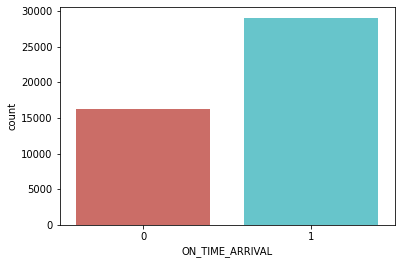

In [9]:
#Investigate suitability of data for logistic regression
#This data is quite imblanaced and could result in reasonably high classifcation by just assuming flights arrive on time.
#This will need to be fixed. We correct this a few sections down, but its important to visualize now. 
import seaborn as sns
dfReduced['ON_TIME_ARRIVAL'].value_counts()

sns.countplot(x='ON_TIME_ARRIVAL',data=dfReduced,palette='hls')

#This section scales the variables to values between 0 and 1 in order to get the data ready for logistic regression.
#We only scale variables that aren't already between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# Scale only columns that have values greater than 1
mms = MinMaxScaler()
dfScaled=dfReduced
dfScaled[["DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]] = mms.fit_transform(dfScaled[["DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]])
print(dfScaled)

#### Data Preperation for Regression

In [84]:
import datetime
dfReg1 =dfReg.copy()

dfReg1['ARR_TIME']=dfReg1['ARR_TIME'].astype(int)
dfReg1['ARR_TIME']=dfReg1['ARR_TIME'].round()
dfReg1['ARR_STRING']=dfReg1['ARR_TIME'].apply(str)

dfReg1['ARR_STRING']=dfReg1['ARR_STRING'].str.pad(width=4,side='left',fillchar='0')
time=(dfReg1.assign(newtime=pd.to_datetime(dfReg1['ARR_STRING'],format='%H%M',errors='coerce')))

time['newtime'] = time['newtime'].dt.strftime('%H:%M')
time['newtime'] = time['newtime'].astype('datetime64').dt.time


dfReg1['CRS_ARR_TIME']=dfReg1['CRS_ARR_TIME'].astype(int)
dfReg1['CRS_ARR_TIME']=dfReg1['CRS_ARR_TIME'].round()
dfReg1['CRS_ARR_STRING']=dfReg1['CRS_ARR_TIME'].apply(str)


dfReg1['CRS_ARR_STRING']=dfReg1['CRS_ARR_STRING'].str.pad(width=4,side='left',fillchar='0')
time=(dfReg1.assign(CRSnewtime=pd.to_datetime(dfReg1['CRS_ARR_STRING'],format='%H%M',errors='coerce')))
time['CRSnewtime'] = time['CRSnewtime'].dt.strftime('%H:%M')
time['CRSnewtime'] = time['CRSnewtime'].astype('datetime64').dt.time




In [85]:
time['CRSnewtime']

929508     19:26:00
2390254    15:55:00
1797438    16:47:00
4821960    10:15:00
4330544    18:41:00
             ...   
2987493    20:32:00
4443275    19:55:00
5364170    08:05:00
5364381    00:55:00
6830663    05:13:00
Name: CRSnewtime, Length: 45284, dtype: object

In [64]:

import matplotlib.pyplot as plt


dfReg1=dfReg.copy()

diff= time['newTime']-dfReg1['CRS_ARR_TIME']

diff=diff/60
print(diff)
plt.hist(diff,bins=200,range=(-2.5,10),log=True)

#Pretty good balance

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [ ]:
print(dfReg['CRS_ARR_TIME'])
print(dfReg['ARR_TIME'])

# Data Preperation Part II

# Modeling and Evaluation 1

# Modeling and Evaluation 2

# Modeling and Evaluation 3

# Modeling and Evaluation 4

# Modeling and Evaluation 5

# Modeling and Evaluation 6

# Deployment

# Exceptional Work

Section not required due to team size